# Homework 4 Part 2

# Problem 1 (25 points)

**In this problem you will be experimenting with a special MLP architecture, known as _autoencoder_ (or AE).**

**An autoencoder attempts to find efficient latent representations of the inputs, it then spits out something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts:**

1. **an encoder (or recognition network) that converts the inputs to a latent representation, followed by**
2. **a decoder (or generative network) that converts the internal representation to the outputs.**

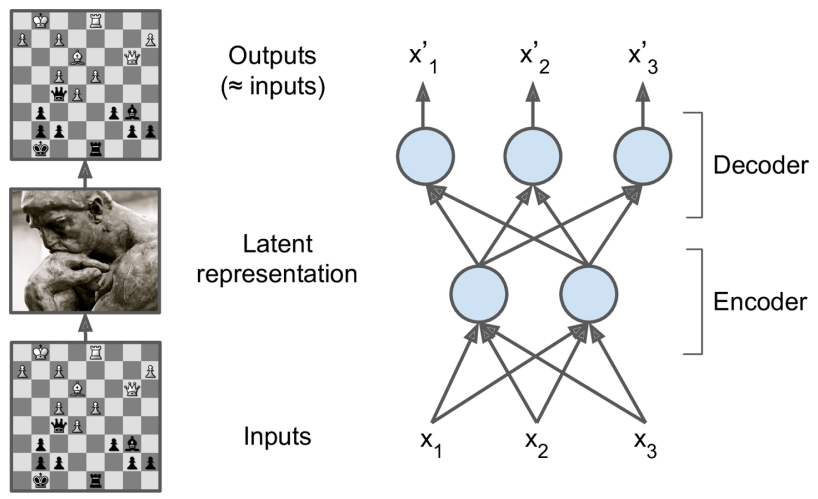

In [1]:
from IPython.display import Image
Image('figures/autoencoder.png', width=400)

**As you can see, an autoencoder typically has the same architecture as a Multi-Layer Perceptron (MLP), except that the number of neurons in the output layer must be equal to the number of inputs. In this example, there is just one hidden layer composed of two neurons (the encoder), and one output layer composed of three neurons (the decoder). The outputs are often called the
reconstructions because the autoencoder tries to reconstruct the inputs, and the cost function contains a reconstruction loss that penalizes the model when the reconstructions are different from the inputs.**

**Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be undercomplete. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).**

**Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case they are called stacked autoencoders (or deep autoencoders). Adding more layers helps the autoencoder learn more complex codings.**

**The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). For example, an autoencoder for the MNIST may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import tensorflow as tf
from tensorflow import keras
from time import time
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
mnist = keras.datasets.mnist

(X_train_full, t_train_full), (X_test, t_test) = mnist.load_data()

X_train_full.shape, t_train_full.shape, X_test.shape, t_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# Training and Validation sets
# First 5,000 samples as validation and the remaining ones as training samples
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
t_valid, t_train = t_train_full[:5000], t_train_full[5000:]
X_test = X_test / 255.0

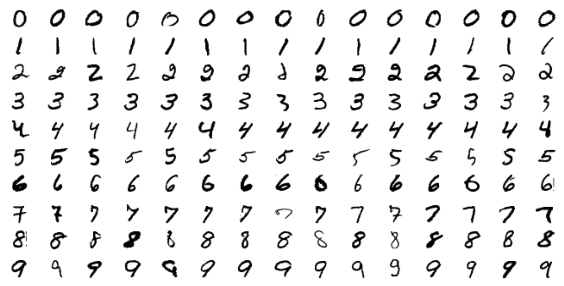

In [5]:
plt.figure(figsize=(10,5))
plot_idx=1
for i in range(10):
    labels = np.where(t_train==i)[0]
    idx = np.random.permutation(range(len(labels)))
    for j in range(1,16):
        plt.subplot(10,15,plot_idx)
        plt.imshow(X_train[labels[j],:,:], cmap='binary')
        plt.axis('off')
        plot_idx+=1

In [7]:
# Reproducible results - fix the random seed generator (doesn't account for GPU-induced randomness)
tf.random.set_seed(2)

# Stacked Auto-Encoder
def stacked_autoencoder(X_train, X_valid, embedding_size=30, input_shape=[28,28], epochs=10):
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(embedding_size, activation='relu')])

    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation='relu', input_shape=[embedding_size]),
        keras.layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid'),
        keras.layers.Reshape(input_shape)])

    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

    stacked_ae.compile(loss=keras.losses.BinaryCrossentropy(),
                       optimizer=keras.optimizers.Adam(),
                      )

    start = time()
    history = stacked_ae.fit(X_train, X_train, epochs=epochs, batch_size=32,
                             validation_data=[X_valid, X_valid])
    print('Elapsed Time: ',time()-start, ' seconds')
    
    return stacked_ae


# Embedding dimensionality
embedding_size = 30

# Training Stacked Autoencoder
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1450 - val_loss: 0.1068
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1024 - val_loss: 0.0976
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0962 - val_loss: 0.0937
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0928 - val_loss: 0.0912
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0909 - val_loss: 0.0901
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0896 - val_loss: 0.0891
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0887 - val_loss: 0.0885
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0880 - val_loss: 0.0879
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0874 - val_loss: 0.0878
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.086

**When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black. Framing it this way (rather than as a regression problem) tends to make the model converge faster.**

**Let's visualize some example reconstructions:**

In [49]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, X_valid, input_shape=[28,28], compute_error=True, n_images=30):
    reconstructions = model.predict(X_valid[:n_images])
    if compute_error:
        error=X_valid[:n_images]-reconstructions
        avg_MSE=np.mean(np.mean(error.reshape((n_images,input_shape[0]*input_shape[1]))**2,axis=1))
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    if compute_error:
        print('Average MSE of reconstruction: ', avg_MSE)

1/1 [==============================] - 0s 70ms/step
Average MSE of reconstruction:  0.008218441185071583


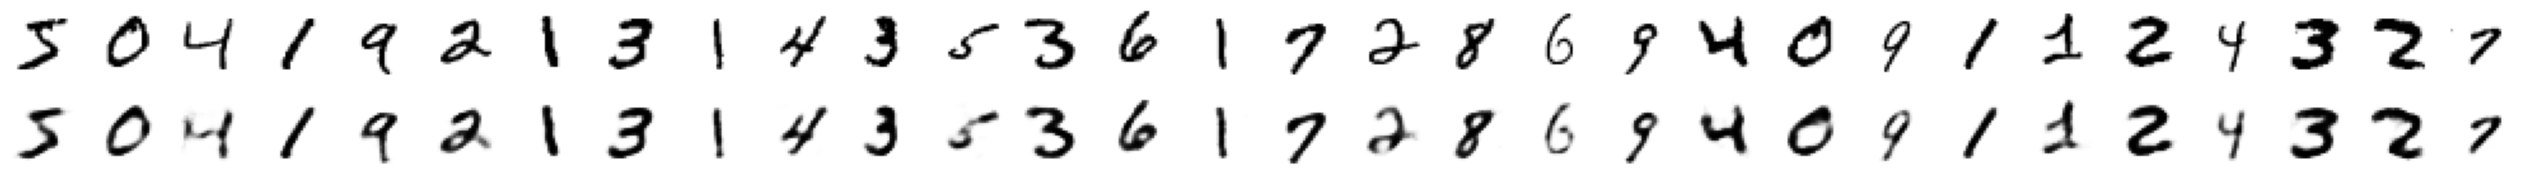

In [9]:
# Show Reconstructions

show_reconstructions(stacked_ae)

### Accessing Outputs at Bottleneck Layer

**To demonstrate this, let's consider a stacked autoencoder with a 2-dimensional bottleneck layer (embedding dimension):**

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2446 - val_loss: 0.2145
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2103 - val_loss: 0.2059
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2054 - val_loss: 0.2027
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2023 - val_loss: 0.1996
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1997 - val_loss: 0.1972
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1976 - val_loss: 0.1951
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1962 - val_loss: 0.1939
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1951 - val_loss: 0.1928
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1941 - val_loss: 0.1923
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.193

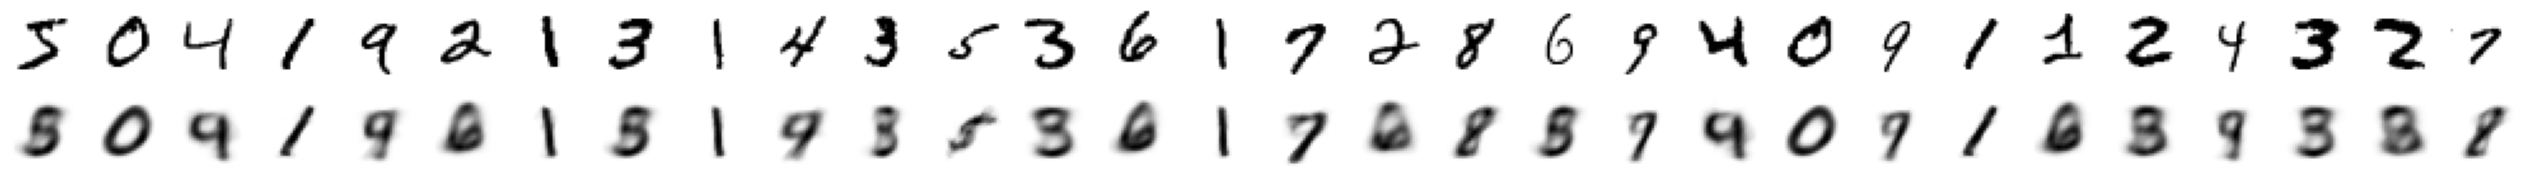

In [10]:
# Embedding dimensionality
embedding_size = 2

# Training Stacked Autoencoder
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)

# Show Reconstructions
show_reconstructions(stacked_ae)

**If you want to access the embedding output produced at the bottleneck layer, you can do the following:**

In [11]:
stacked_ae.layers

# The "1st layer" corresponds ot the stacked encoder
# The "2nd layer" corresponds ot the stacked decoder

In [12]:
enc = stacked_ae.layers[0]
enc.layers

# As you can see, the stacked encoder contains a reshaping layer (flatten), 1st hidden layer and the bottleneck layer.
# Let's obtain the output at each layer and pass it to the next

In [13]:
flatten = enc.layers[0](X_train)
hidden1 = enc.layers[1](flatten)
bottleneck = enc.layers[2](hidden1)

In [14]:
bottleneck.shape

TensorShape([55000, 2])

As expected, the bottleneck layer mapped all 55,000 training images to a 2-dimensional space. Since its 2-D, we can visualize it:

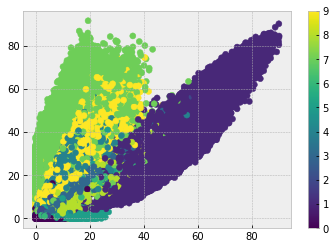

In [15]:
plt.scatter(bottleneck[:,0], bottleneck[:,1], c=t_train)
plt.colorbar();

**Answer the following questions:**

1. (7 points) **Experiment with different embedding dimensions (at least 3 values). At least a "very small" embedding space (like 2), "very large" embedding space (like 90), and another in between. Discuss your observations regarding the speed of training, quality of reconstruction images, and the reconstruction average MSE.**

2. (11 points) **Compare the stacked AE reconstructions with those produced with PCA (for the same embedding dimensionality). Discuss your observations based on reconstruction visualization and average MSE.** 

3. (7 points) **For what autoencoder design (architecture, activation functions and objective function), will an autoencoder be producing the same results as PCA? Justify your answer.**

1. Answers to problem 1 are experimental and shown below:

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2408 - val_loss: 0.2153
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2116 - val_loss: 0.2072
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2056 - val_loss: 0.2019
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2019 - val_loss: 0.1992
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1997 - val_loss: 0.1973
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1979 - val_loss: 0.1953
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1961 - val_loss: 0.1939
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1947 - val_loss: 0.1926
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1935 - val_loss: 0.1915
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.192

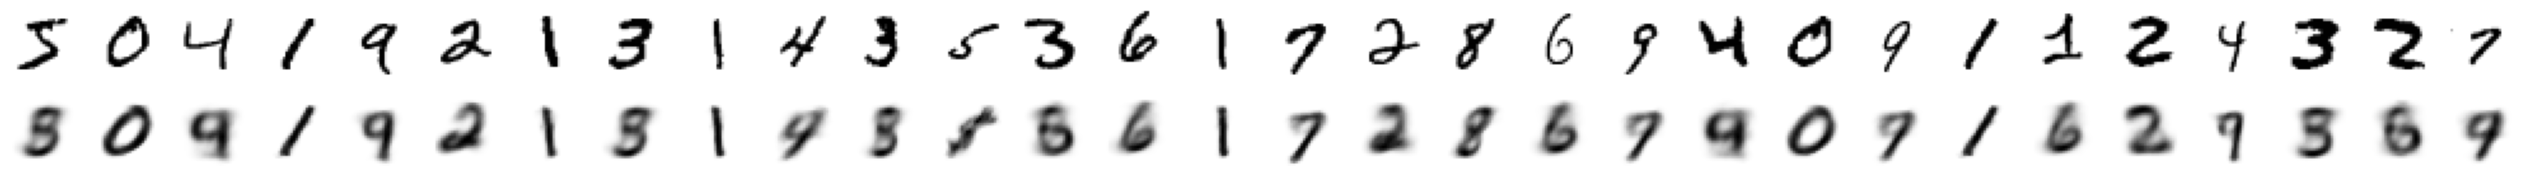

In [16]:
embedding_size = 2
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)
show_reconstructions(stacked_ae)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1356 - val_loss: 0.0990
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0925 - val_loss: 0.0877
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0857 - val_loss: 0.0835
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0823 - val_loss: 0.0812
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0798 - val_loss: 0.0793
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0781 - val_loss: 0.0782
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0770 - val_loss: 0.0767
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0761 - val_loss: 0.0760
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0754 - val_loss: 0.0756
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.074

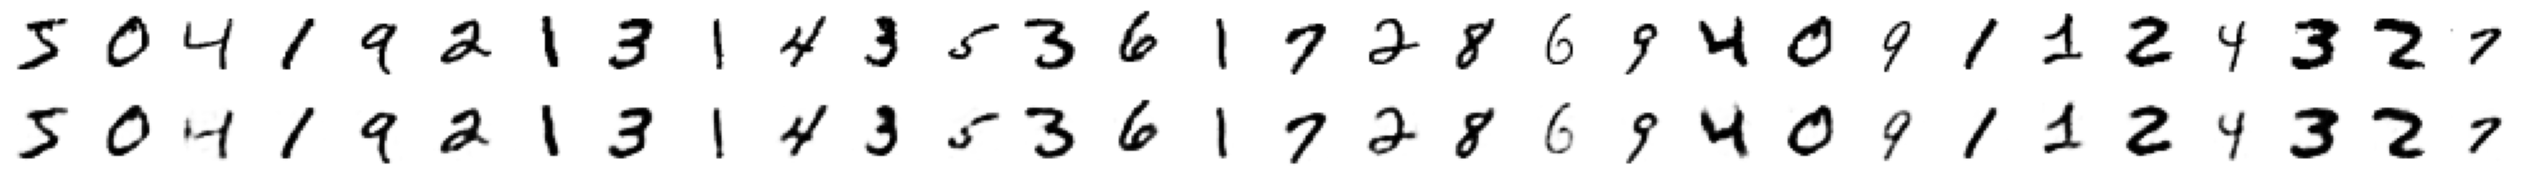

In [17]:
embedding_size = 90
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)
show_reconstructions(stacked_ae)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1471 - val_loss: 0.1093
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1032 - val_loss: 0.0985
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0966 - val_loss: 0.0945
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0938 - val_loss: 0.0924
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0919 - val_loss: 0.0910
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0906 - val_loss: 0.0898
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0896 - val_loss: 0.0896
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0888 - val_loss: 0.0886
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0882 - val_loss: 0.0881
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.087

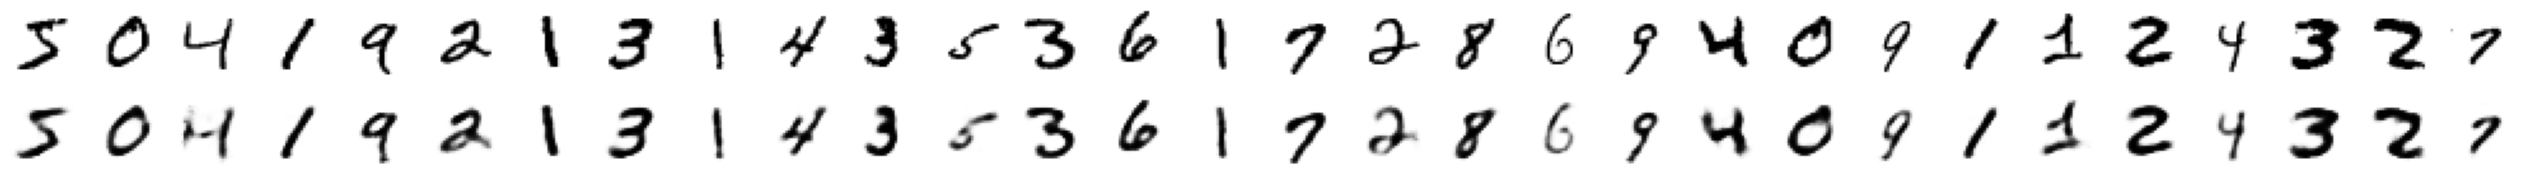

In [18]:
embedding_size = 30
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)
show_reconstructions(stacked_ae)

As we can see, when the embedding dimension is 2, the reconstructions are much more lossy compared to larger dimensionality embedding.
Between embedding dimensionality 30 and 90, I do not see a big change in the images but the average MSE is slightly smaller for embedding dimension 90 compared to 30, which is expected.

2. To answer this question, I will compare the reconstruction of PCA with:

    * a stacked autoencoder with 1 hidden layer with 100 units and an embedding hidden layer with 30 units (embedding dimension).
    * an autoencoder (single hidden layer) with 30 units. This AE will be have: (1) linear activation functions, resulting in simple linear transformations (that is, matrix multiplications, like PCA); (2) demeaning data. PCA must work with mean-centered data.

In [19]:
# Stacked Auto-Encoder
def autoencoder(X_train, X_valid, embedding_size=30, input_shape=[28,28], epochs=10, activation='relu', 
                use_bias=True, loss=keras.losses.BinaryCrossentropy(), demean=False):
    
    encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(embedding_size, activation=activation, use_bias=use_bias)])

    decoder = keras.models.Sequential([
        keras.layers.Dense(input_shape[0] * input_shape[1], activation=activation, 
                           input_shape=[embedding_size], use_bias=use_bias),
        keras.layers.Reshape(input_shape)])

    ae = keras.models.Sequential([encoder, decoder])

    ae.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(),
                      )

    if demean:
        X_train = X_train - np.mean(X_train, axis=0)
        X_valid = X_valid - np.mean(X_valid, axis=0)
        
    start = time()
    history = ae.fit(X_train, X_train, epochs=epochs, batch_size=32,
                             validation_data=[X_valid, X_valid])
    print('Elapsed Time: ',time()-start, ' seconds')
    
    return ae

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1357 - val_loss: 0.0981
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0926 - val_loss: 0.0878
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0855 - val_loss: 0.0833
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0820 - val_loss: 0.0806
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0798 - val_loss: 0.0794
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0783 - val_loss: 0.0795
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0772 - val_loss: 0.0769
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0762 - val_loss: 0.0763
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0755 - val_loss: 0.0758
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.074

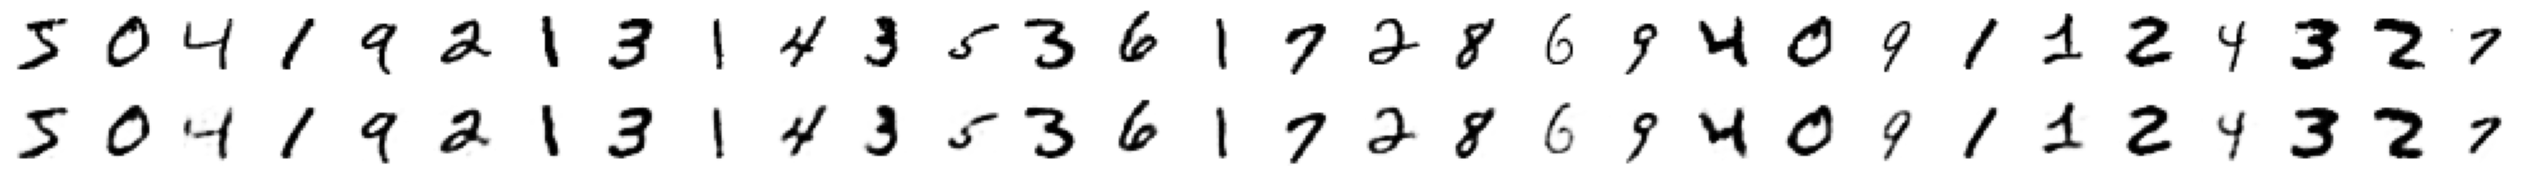

In [20]:
## Stacked Autoencoder

embedding_size = 90
stacked_ae = stacked_autoencoder(X_train, X_valid, embedding_size)
show_reconstructions(stacked_ae)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2765 - val_loss: 0.2532
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2777 - val_loss: 0.2624
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2277 - val_loss: 0.2060
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2493 - val_loss: 0.2491
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2418 - val_loss: 0.2312
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2629 - val_loss: 0.2879
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2770 - val_loss: 0.2475
Epoch 8/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2397 - val_loss: 0.2421
Epoch 9/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2367 - val_loss: 0.2188
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.231

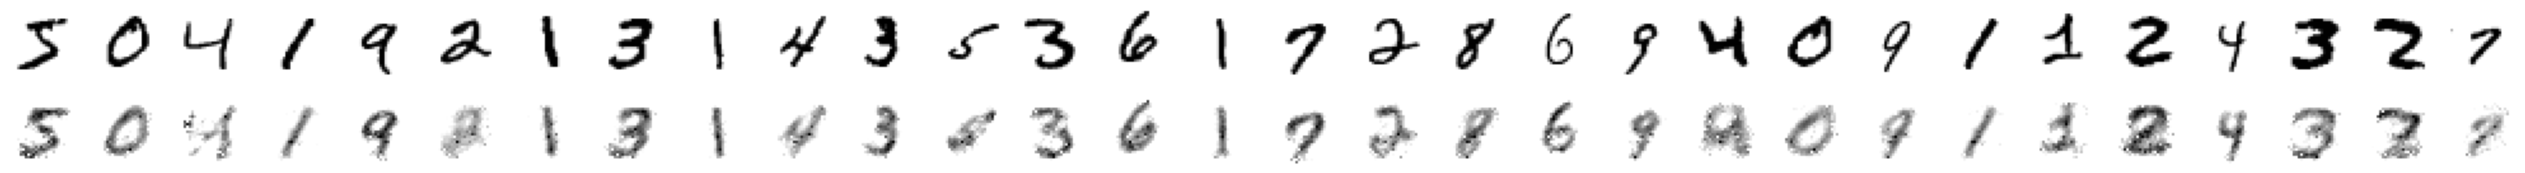

In [21]:
## Autoencoder

embedding_size = 90
ae = autoencoder(X_train, X_valid, embedding_size)
show_reconstructions(ae)

We can clearly see the difference adding one more hidden layer in the encoder/decoder makes in the reconstruction.

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0217 - val_loss: 0.0182
Epoch 2/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.0184 - val_loss: 0.0182
Epoch 3/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.0184 - val_loss: 0.0182
Epoch 4/10
1719/1719 [==============================] - 2s 968us/step - loss: 0.0183 - val_loss: 0.0182
Epoch 5/10
1719/1719 [==============================] - 2s 974us/step - loss: 0.0183 - val_loss: 0.0182
Epoch 6/10
1719/1719 [==============================] - 2s 961us/step - loss: 0.0183 - val_loss: 0.0181
Epoch 7/10
1719/1719 [==============================] - 2s 970us/step - loss: 0.0183 - val_loss: 0.0181
Epoch 8/10
1719/1719 [==============================] - 2s 968us/step - loss: 0.0183 - val_loss: 0.0181
Epoch 9/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.0183 - val_loss: 0.0181
Epoch 10/10
1719/1719 [==============================] - 2s 977us/

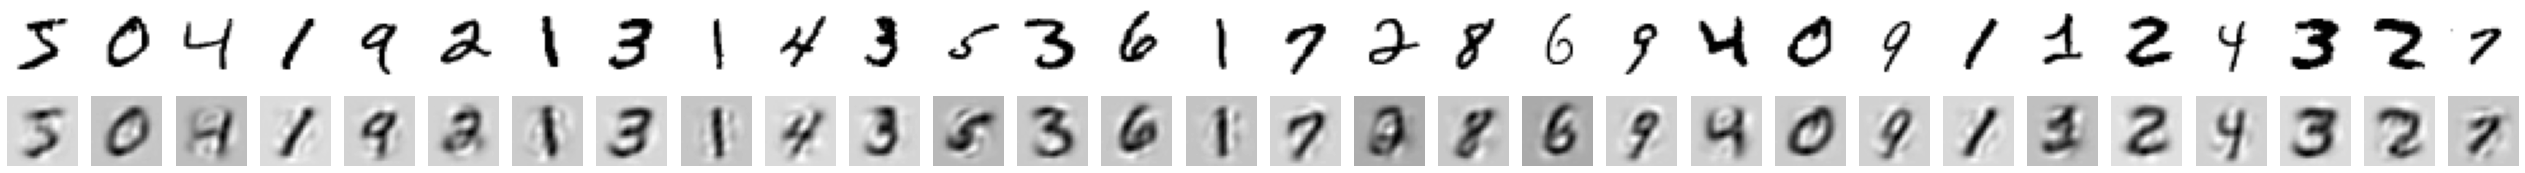

In [22]:
## Autoencoder with Linear Activation Function (similar to PCA)

embedding_size = 30
ae = autoencoder(X_train, X_valid, embedding_size, activation='linear', use_bias=False, 
                 loss=keras.losses.MeanSquaredError(), demean=True)
show_reconstructions(ae)

In [23]:
def show_reconstructions_PCA(model, n_images=30):
    reconstructions = model.inverse_transform(model.transform(X_valid_reshape[:n_samples]))
    error=X_valid_reshape[:n_images]-reconstructions
    avg_MSE=np.mean(np.mean(error**2,axis=1))
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid_reshape[image_index].reshape(28,28))
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index].reshape(28,28))
    print('Average MSE of reconstruction: ', avg_MSE)

In [24]:
X_train_reshape = X_train.reshape(X_train.shape[0], 784)
X_valid_reshape = X_valid.reshape(X_valid.shape[0], 784)
X_test_reshape = X_test.reshape(X_test.shape[0], 784)

X_train_reshape.shape, X_valid_reshape.shape, X_test_reshape.shape

((55000, 784), (5000, 784), (10000, 784))

Average MSE of reconstruction:  0.017652620316229706


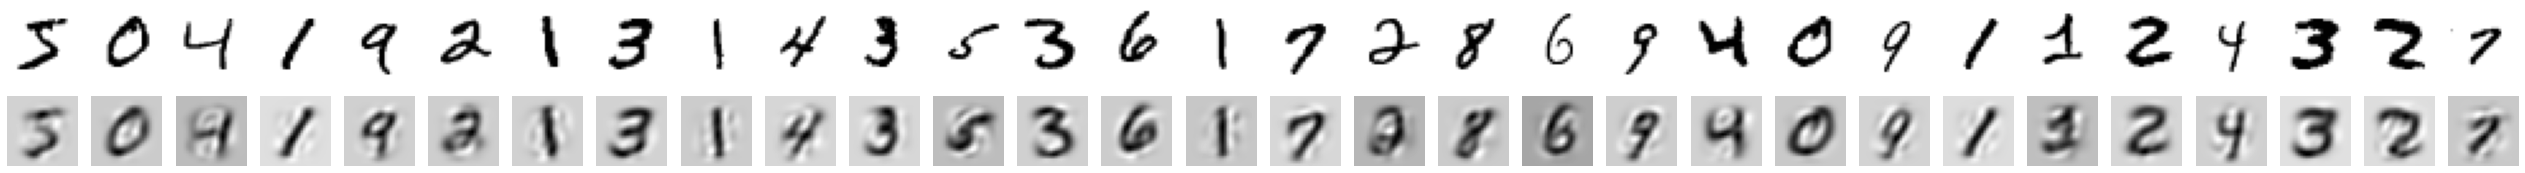

In [25]:
from sklearn.decomposition import PCA

embedding_size = 30
n_samples = 30
pca = PCA(n_components=embedding_size)
pca.fit(X_train_reshape)

show_reconstructions_PCA(pca)

3. If the autoencoder only contains 1 hidden layer (embedding layer), no bias terms, linear activation functions, and the cost function is the mean squared error (MSE), then it ends up performing Principal Component Analysis.

Recall that PCA is a simple linear transformation, that is, matrix multiplication of the form: $\mathbf{Y} = \mathbf{A}\tilde{\mathbf{X}}$. If the encoder satisfies the properties listed above, then we are carrying a simple matrix multiplication. Note that $\tilde{\mathbf{X}}$ is the mean-centered data matrix (requirement of PCA). The ```sklearn.decomposition.PCA``` already applies this operation prior to finding the PCA projections.

___

# Problem 2 (7.5 points)

**For this problem, consider the final project training data. Feel free to discuss with your team, but this is an individual assignment.**

In [33]:
X_train = np.load('data_train.npy').T
t_train = np.load('t_train.npy') # or np.load('t_train_corrected.npy')

X_train.shape, t_train.shape

((9032, 90000), (9032,))

You can convert ```numpy``` arrays to ```tensorflow``` tensors with:

In [34]:
X_train_tf = tf.constant(X_train.reshape(X_train.shape[0], 300, 300))

X_train_tf.shape

TensorShape([9032, 300, 300])

**Answer the following questions:**

1. (1 point) **Split your data into training and validation sets. Use a stratified 80/20 partition with a fixed ```random_state``` (in order to avoid data leakage).**

2. (3.5 points) **Train a stacked autoencoder with an embedding dimension of at least 100-dimensional.**

3. (3 points) **Visualize the embedding projections for training and validation sets.**

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_valid, t_train, t_valid = train_test_split(X_train, t_train, 
                                                      test_size=0.2, 
                                                      stratify=t_train,
                                                      random_state=0)

X_train.shape, X_valid.shape, t_train.shape, t_valid.shape

((7225, 90000), (1807, 90000), (7225,), (1807,))

In [36]:
# Scaling data

X_train = X_train/255.0
X_valid = X_valid/255.0

In [37]:
X_train_tf = tf.constant(X_train.reshape(X_train.shape[0], 300, 300))
X_valid_tf = tf.constant(X_valid.reshape(X_valid.shape[0], 300, 300))

X_train_tf.shape, X_valid_tf.shape

(TensorShape([7225, 300, 300]), TensorShape([1807, 300, 300]))

I will modify the ```stacked_autoencoder``` function from earlier, because a 90,000 to 100 compression in the first hidden layer may be too much. I welcome you to try to see the results.

I will use a stacked autoencoder with the following architecture: 90,000 - 3000 - N - 3000 - 90,000, where N is the embedding dimension.

As expected, the more layers, the more expensive training will become.

In [56]:
# Reproducible results - fix the random seed generator (doesn't account for GPU-induced randomness)
tf.random.set_seed(2)

# Stacked Auto-Encoder
def stacked_autoencoder2(X_train, X_valid, embedding_size=30, input_shape=[28,28], epochs=10):
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.Dense(3000, activation='relu'),
#         keras.layers.Dense(500, activation='relu'),
        keras.layers.Dense(embedding_size, activation='relu')])

    stacked_decoder = keras.models.Sequential([
#         keras.layers.Dense(500, activation='relu', input_shape=[embedding_size]),
        keras.layers.Dense(3000, activation='relu', input_shape=[embedding_size]),
        keras.layers.Dense(input_shape[0] * input_shape[1], activation='sigmoid'),
        keras.layers.Reshape(input_shape)])

    stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

    stacked_ae.compile(loss=keras.losses.BinaryCrossentropy(),
                       optimizer=keras.optimizers.Adam(),
                      )

    start = time()
    history = stacked_ae.fit(X_train, X_train, epochs=epochs, batch_size=32,
                             validation_data=[X_valid, X_valid])
    print('Elapsed Time: ',time()-start, ' seconds')
    
    return stacked_ae

Epoch 1/10
226/226 [==============================] - 338s 1s/step - loss: 0.5968 - val_loss: 0.5845
Epoch 2/10
226/226 [==============================] - 328s 1s/step - loss: 0.5878 - val_loss: 0.5766
Epoch 3/10
226/226 [==============================] - 320s 1s/step - loss: 0.5800 - val_loss: 0.5673
Epoch 4/10
226/226 [==============================] - 321s 1s/step - loss: 0.5674 - val_loss: 0.5516
Epoch 5/10
226/226 [==============================] - 322s 1s/step - loss: 0.5568 - val_loss: 0.5447
Epoch 6/10
226/226 [==============================] - 877s 4s/step - loss: 0.5524 - val_loss: 0.5420
Epoch 7/10
226/226 [==============================] - 326s 1s/step - loss: 0.5494 - val_loss: 0.5404
Epoch 8/10
226/226 [==============================] - 320s 1s/step - loss: 0.5481 - val_loss: 0.5413
Epoch 9/10
226/226 [==============================] - 320s 1s/step - loss: 0.5466 - val_loss: 0.5408
Epoch 10/10
226/226 [==============================] - 4326s 19s/step - loss: 0.5460 - val_

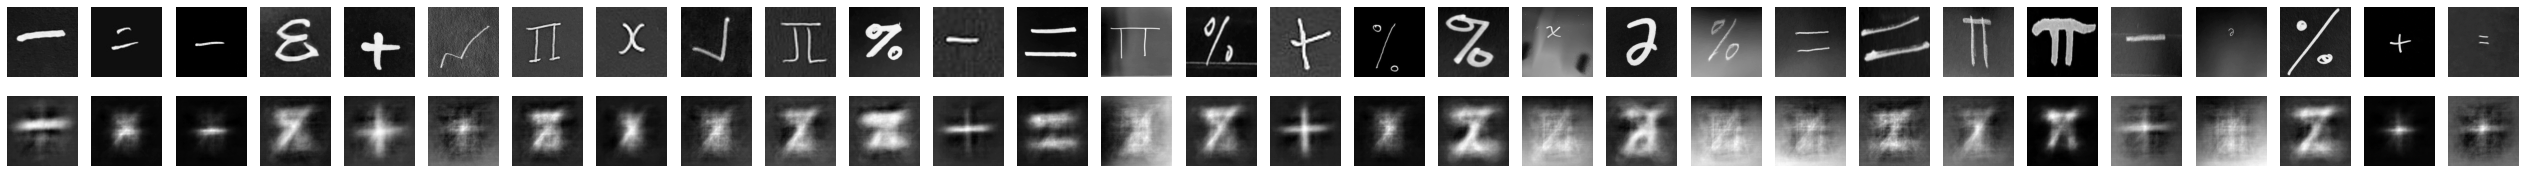

In [57]:
# Embedding dimensionality
embedding_size = 1000

# Training Stacked Autoencoder
stacked_ae = stacked_autoencoder2(X_train_tf, X_valid_tf, embedding_size, input_shape=[300,300])

# Show Reconstructions for Validation
show_reconstructions(stacked_ae, X_valid_tf, [300,300], False)

1/1 [==============================] - 4s 4s/step


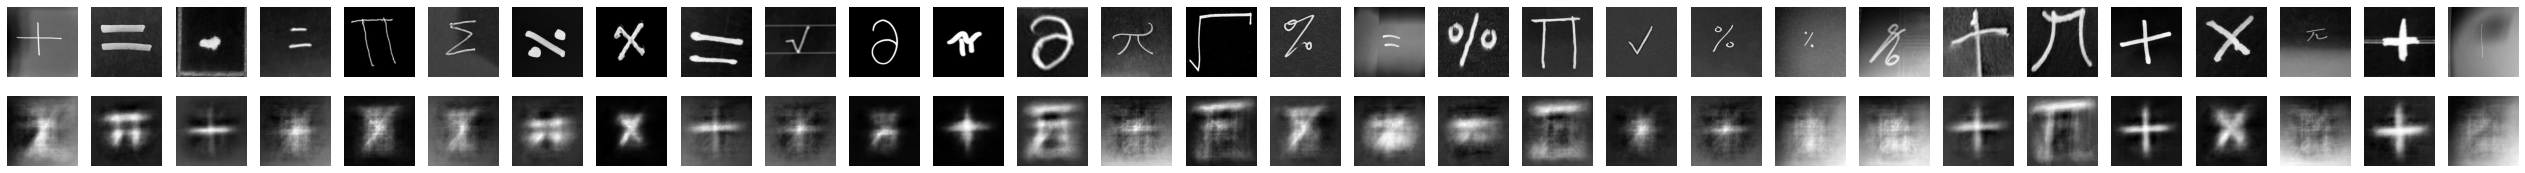

In [100]:
# Show Reconstructions for Training
show_reconstructions(stacked_ae, X_train_tf, [300,300], False)

---

# Problem 3 (15 points)

**In this problem, you will be working with the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). The California Housing dataset consists of 20,640 samples, each described with 8 features. Let's import it:**

In [3]:
from sklearn.datasets import fetch_california_housing 
housing = fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
X = housing.data # feature matrix (attributes/features are described above)

t = housing.target # target vector (median house value expressed in $100,000)

X.shape, t.shape

((20640, 8), (20640,))

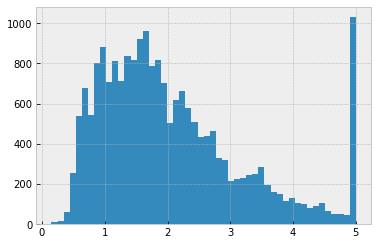

In [13]:
plt.hist(t, bins=50);

The distribution of the target variable is not uniform. So a random partition may result in one of the sets not containing samples with large median income values.

We can encode the target values to labels and use those to perform a stratified partition.

Below is an example of a categorical encoding:

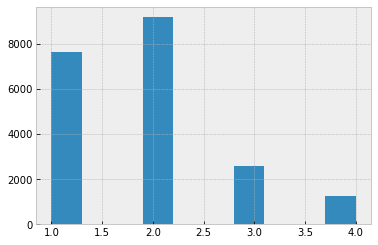

In [12]:
import pandas as pd
income_cat = pd.cut(t, 
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                    labels=[1, 2, 3, 4, 5])

plt.hist(income_cat);

**Answer the following questions:**

1. (1 point) **Partition the data into a *full training set* and a test set. Use a 80/20 stratified split with a fixed ```random_state```. Then partition the *full training set* into a train set and a validation set. For this last partition, use a 70/30 stratified split with a fixed ```random_state```.**

In [20]:
from sklearn.model_selection import train_test_split 

X_train_full, X_test, t_train_full, t_test, income_cat_training, income_cat_test = train_test_split(X, t, income_cat,
                                                                                                 test_size=0.2, 
                                                                                                 stratify=income_cat,
                                                                                                 random_state=0) 

X_train, X_valid, t_train, t_valid, income_cat_train, income_cat_valid = train_test_split(X_train_full, 
                                                                                          t_train_full, income_cat_train,
                                                                                          test_size=0.3,
                                                                                          stratify=income_cat_train,
                                                                                          random_state=0) 

X_train.shape, X_valid.shape, X_test.shape, t_train.shape, t_valid.shape, t_test.shape

((11558, 8), (4954, 8), (4128, 8), (11558,), (4954,), (4128,))

2. (1 point) **Apply the standardization scaling to the train, validation and test sets. Use the train set to find the mean and standard deviation.**

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid) 
X_test = scaler.transform(X_test)

X_train.shape, t_train.shape, X_valid.shape, t_valid.shape, X_test.shape, t_test.shape

((11558, 8), (11558,), (4954, 8), (4954,), (4128, 8), (4128,))

3. (5 points) **Use the Sequential API to build an MLP with 2 hidden layers with the Leaky ReLU activation function and associated ```alpha=0.2```. The first hidden layer should have 50 neurons and the second 10 neurons. How many neurons should you include in the input and output layers? what should be the activation function in the output layer?**

The input layer will have as many input neurons as there are attributes, thus a total of 8 units. The output layer will have as many units as the dimensionality of the target response. In this case our target is 1-D, for each sample, we wish to predict its median value.

As seen below, since the target is always positive (not scaled), and greater than 1, the most activation functions for the output layer are the ReLU or linear functions.

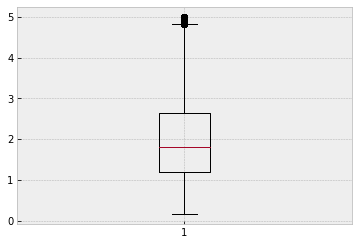

In [22]:
plt.boxplot(t);

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[8]),
    keras.layers.Dense(50),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(10),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(1, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 50)                450       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 971
Trainable params: 971
Non-trainable pa

4. (3 points) **Compile the model with the Mean Squared Error [loss function](https://keras.io/api/losses/), the Adam [optimizer](https://keras.io/api/optimizers/) with learning rate of 0.001, and the ```MeanSquaredError``` [performance metric](https://keras.io/api/metrics/).**

In [24]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=keras.metrics.MeanSquaredError(name='mse'))

5. (2 points) **Train the model using the train and validation sets with online learning, 200 epochs and early stopping callback with a patience of 10 (on the loss value for the validation set). Plot the learning curves. Discuss your observations.**


In [26]:
history = model.fit(X_train, t_train, epochs=200, batch_size=32,
                    validation_data=(X_valid, t_valid),
                    callbacks=keras.callbacks.EarlyStopping(patience=10))

Epoch 1/200
362/362 [==============================] - 1s 3ms/step - loss: 0.4160 - mse: 0.4160 - val_loss: 0.4253 - val_mse: 0.4253
Epoch 2/200
362/362 [==============================] - 1s 2ms/step - loss: 0.4099 - mse: 0.4099 - val_loss: 0.4231 - val_mse: 0.4231
Epoch 3/200
362/362 [==============================] - 1s 3ms/step - loss: 0.3973 - mse: 0.3973 - val_loss: 0.4077 - val_mse: 0.4077
Epoch 4/200
362/362 [==============================] - 1s 2ms/step - loss: 0.3916 - mse: 0.3916 - val_loss: 0.4102 - val_mse: 0.4102
Epoch 5/200
362/362 [==============================] - 1s 3ms/step - loss: 0.3835 - mse: 0.3835 - val_loss: 0.3956 - val_mse: 0.3956
Epoch 6/200
362/362 [==============================] - 1s 2ms/step - loss: 0.3781 - mse: 0.3781 - val_loss: 0.3916 - val_mse: 0.3916
Epoch 7/200
362/362 [==============================] - 1s 2ms/step - loss: 0.3706 - mse: 0.3706 - val_loss: 0.3852 - val_mse: 0.3852
Epoch 8/200
362/362 [==============================] - 1s 3ms/step - 

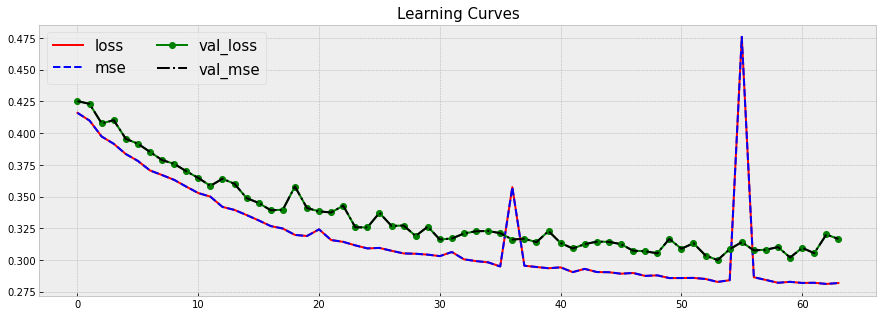

In [27]:
key_names = list(history.history.keys())
colors = ['-r','--b','-og','-.k']

plt.figure(figsize=(15,5))
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves', size=15);

6. (2 points) **Evaluate the mean squared error performance in the train and test sets.**

In [28]:
mse_train = model.evaluate(X_train, t_train)

mse_test = model.evaluate(X_test, t_test)

129/129 [==============================] - 0s 2ms/step - loss: 0.3280 - mse: 0.3280


7. (2 points) **Predict the housing prices for the train and test sets. Use these predictions to calculate the [$r^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).**

In [29]:
y_train = model.predict(X_train)
y_valid = model.predict(X_valid)
y_test = model.predict(X_test)

129/129 [==============================] - 0s 2ms/step


In [31]:
from sklearn.metrics import r2_score

print(r2_score(t_train, y_train))
print(r2_score(t_valid, y_valid))
print(r2_score(t_test, y_test))

0.7831873273221006
0.7619121447993056
0.753492223797148


___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.